In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd 
from IPython.display import display, Math
from scipy.spatial import distance 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Best practice source:
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(72730)))

In [3]:
p = 5
rho = .8
Sigma = np.full((p, p), rho)
np.fill_diagonal(Sigma, 1)
print(Sigma)

[[1.  0.8 0.8 0.8 0.8]
 [0.8 1.  0.8 0.8 0.8]
 [0.8 0.8 1.  0.8 0.8]
 [0.8 0.8 0.8 1.  0.8]
 [0.8 0.8 0.8 0.8 1. ]]


A) The marginal distribution of $(Y_1, Y_2)$ is MVN with $\mu = (0, 0)'$ and $\Sigma =$

In [4]:
print(Sigma[:2, :2])

[[1.  0.8]
 [0.8 1. ]]


B) The conditional distribution of $(Y_1, Y_2)|Y_3, Y_4, Y_5$ is MVN. We calculate the mean $\bar\mu$ and covariance matrix $\bar\Sigma$ of this distribution below: 

In [5]:
mu1 = np.array([0, 0])
mu2 = np.array([0, 0, 0])
givens = np.array([0.23, -0.65, -0.3])
sig22inv = LA.inv(Sigma[-3:, -3:])
mubar = mu1 + LA.multi_dot([Sigma[:2, -3:], sig22inv, givens])
display(Math(r'\bar\mu :'))
print(mubar)
sigbar = Sigma[:2, :2] - LA.multi_dot([Sigma[:2, -3:], sig22inv, Sigma[-3:, :2]])
display(Math(r'\bar\Sigma :'))
print(sigbar)

<IPython.core.display.Math object>

[-0.22153846 -0.22153846]


<IPython.core.display.Math object>

[[0.26153846 0.06153846]
 [0.06153846 0.26153846]]


C) The $L$ in $\Sigma = LL'$ comes from the Cholesky decomposition of $\Sigma$. It is one varaition on the square root of $\Sigma$. In this example, $L$ is: 

In [6]:
choleskyL = LA.cholesky(Sigma)
print(choleskyL)

[[1.         0.         0.         0.         0.        ]
 [0.8        0.6        0.         0.         0.        ]
 [0.8        0.26666667 0.53748385 0.         0.        ]
 [0.8        0.26666667 0.16537965 0.51140831 0.        ]
 [0.8        0.26666667 0.16537965 0.12033137 0.49705012]]


D) $L^{-1}$ is: 

In [7]:
print(LA.inv(choleskyL))

[[ 1.          0.          0.          0.          0.        ]
 [-1.33333333  1.66666667  0.          0.          0.        ]
 [-0.82689823 -0.82689823  1.86052102  0.          0.        ]
 [-0.60165684 -0.60165684 -0.60165684  1.95538472  0.        ]
 [-0.47338107 -0.47338107 -0.47338107 -0.47338107  2.01186954]]


E) The $A$ in $A = PD^{1/2}$ is from the spectral/eigen decomposition of $\Sigma$. It is another variation on the square root of $\Sigma$. In this example, A is:

In [8]:
spectral_components = LA.eigh(Sigma)

In [9]:
p = spectral_components[1]
dsqrt = np.diag(np.sqrt(spectral_components[0]))
(p @ dsqrt).round(8)

array([[-0.39303622,  0.        ,  0.        , -0.07431374,  0.91651514],
       [ 0.02630509,  0.        ,  0.        ,  0.39913412,  0.91651514],
       [ 0.12224371, -0.0806617 , -0.35612782, -0.10827346,  0.91651514],
       [ 0.12224371,  0.34874659,  0.10820883, -0.10827346,  0.91651514],
       [ 0.12224371, -0.26808489,  0.24791899, -0.10827346,  0.91651514]])

In [10]:
# We can reconstruct the original as desired 
p @ dsqrt @ dsqrt @ p.T

array([[1. , 0.8, 0.8, 0.8, 0.8],
       [0.8, 1. , 0.8, 0.8, 0.8],
       [0.8, 0.8, 1. , 0.8, 0.8],
       [0.8, 0.8, 0.8, 1. , 0.8],
       [0.8, 0.8, 0.8, 0.8, 1. ]])

F) Simulate 10,000 observations iid, $N(0, \Sigma)$ and calculate the MLE of $\mu$ and $\Sigma$. 
The MLE of $\mu$ is a vector of $\bar X_i$. 
The MLE of $\Sigma$ is $\frac{1}{n}\sum(X_i - \bar X)(X_i - \bar X)'$. It is a baised estimator. 

We sample this data by drawing from the standard normal and calculating $Y = \mu + PD^{1/2}Z$

In [11]:
# Draw from the standard normal and scale
simdata = p @ dsqrt @ np.random.normal(size=(5, 10000))
df = pd.DataFrame(simdata).T
df.head(10)

,0,1,2,3,4
0,0.194507,-0.606890,0.176470,-1.087759,-0.515141
1,0.578737,0.199670,0.395919,-0.014343,-0.625791
2,-0.221497,0.253363,-0.109596,0.526614,-0.295863
3,0.784337,0.742107,1.075592,1.454302,1.372609
4,-0.751715,-0.450782,-0.803568,-1.472787,-1.057527
5,-1.876924,-1.327432,-0.355233,-1.907918,-0.744109
6,1.127785,-0.231445,0.351097,0.470698,0.336787
7,-0.114207,0.731383,0.679120,0.441572,1.214680
8,0.013644,0.410002,0.770535,0.155117,0.302383
9,-0.221710,-0.280177,-0.119045,0.088447,-0.801672


In [12]:
# Calculate Xbar in pandas 
xbar = df.apply(np.mean, axis=0).values
display(Math(r'\hat\mu :'))
print(xbar)

<IPython.core.display.Math object>

[0.01237842 0.00842801 0.00486766 0.00474506 0.00719187]


In [13]:
# Loop-de-loop
sighat = np.zeros(Sigma.shape)
for idx, row in df.iterrows():
    tmp = (row.values-xbar)[:, np.newaxis]
    sighat += tmp @ tmp.T
sighat /= df.shape[0]
display(Math(r'\hat\Sigma :'))
print(sighat)

<IPython.core.display.Math object>

[[1.03051122 0.83320672 0.829584   0.83699397 0.83297075]
 [0.83320672 1.02913912 0.82751446 0.83423774 0.83246174]
 [0.829584   0.82751446 1.0255583  0.83542976 0.82872725]
 [0.83699397 0.83423774 0.83542976 1.04666139 0.84102752]
 [0.83297075 0.83246174 0.82872725 0.84102752 1.04253793]]


G) Repeat the above with $n=50$

In [14]:
# Draw from the standard normal and scale
simdata1 = p @ dsqrt @ np.random.normal(size=(5, 50))
df1 = pd.DataFrame(simdata1).T
df1.head(10)
# Calculate Xbar in pandas 
xbar1 = df1.apply(np.mean, axis=0).values
display(Math(r'\hat\mu :'))
print(xbar1)
# Loop-de-loop
sighat1 = np.zeros(Sigma.shape)
for idx, row in df1.iterrows():
    tmp = (row.values-xbar1)[:, np.newaxis]
    sighat1 += tmp @ tmp.T
sighat1 /= df1.shape[0]
display(Math(r'\hat\Sigma :'))
print(sighat1)

<IPython.core.display.Math object>

[0.10685611 0.20621629 0.11259098 0.11403999 0.1126731 ]


<IPython.core.display.Math object>

[[0.84077475 0.73495219 0.53862276 0.74153233 0.66754285]
 [0.73495219 0.80476525 0.54879704 0.7278729  0.65249694]
 [0.53862276 0.54879704 0.65992149 0.58655239 0.53532496]
 [0.74153233 0.7278729  0.58655239 0.96225316 0.70484177]
 [0.66754285 0.65249694 0.53532496 0.70484177 0.77125384]]


G) The MLE of L is the Cholesky decomposition of the MLE of $\Sigma$. 

Part 2: Write function to evaluate the log-likelihood of MVN. 

In [15]:
def logL(Y, mu, Sigma):
    # Check Sigma is positive definite 
    if not np.all(LA.eigvals(Sig_true) > 0):
        return np.nan
    cost = np.log(abs(LA.det(Sigma))) * Y.shape[0]
    # Use the Mahalanobis distance bulitin to vectorize 
    Sinv = LA.inv(Sigma)
    for i in range(Y.shape[0]):
        cost += distance.mahalanobis(Y[i, :], mu, Sinv)**2
    # Scale cost and return 
    cost *= -0.5
    return(cost)

Fix arbitrary values for $\mu$, $\Sigma$ and test a range of values to maximize logL

In [16]:
# True means 
mu_true = np.array([5, -2])
# True Sigma, verify is positive definite 
Sig_true = np.array([[2, .65],[.65, 1.25]])
print(np.all(LA.eigvals(Sig_true) > 0))
X = np.random.multivariate_normal(mu_true, Sig_true, 500)

True


In [17]:
# Builds pd.DataFrame where all values are the true values, except 
# one column will be a range of values to test 
class SampleData:
    
    def __init__(self, target, test_n=1000, mu_true=mu_true, Sig_true=Sig_true):
        self.target = target
        self.test_n = test_n 
        self.mu_true = mu_true
        self.Sig_true = Sig_true
        self.build_target_data()
        self.data = self.build_test_data()
        
    def build_target_data(self):
        self.target_data = {
        "mu1" : np.linspace(2, 7, num=self.test_n),
        "mu2" : np.linspace(-5, 1, num=self.test_n),
        "sig11" : np.linspace(0.5, 5, num=self.test_n),
        "sig12" : np.linspace(-1, 1, num=self.test_n),
        "sig22" : np.linspace(0.5, 5, num=self.test_n)
    }
    
    def build_test_data(self):
        data = {
            "mu1" : np.repeat(self.mu_true[0], self.test_n),
            "mu2" : np.repeat(self.mu_true[1], self.test_n),
            "sig11" : np.repeat(self.Sig_true[0,0], self.test_n),
            "sig12" : np.repeat(self.Sig_true[0,1], self.test_n),
            "sig22" : np.repeat(self.Sig_true[1,1], self.test_n)
        }
        data[self.target] = self.get_target_values()
        return(pd.DataFrame(data))
        
    def get_target_values(self):
        try:
            data = self.target_data[self.target]
            return(data)
        except ValueError: 
            valid = ",".join(list(self.target_data.keys()))
            print(f"Please select one of the following: {valid}")
            raise

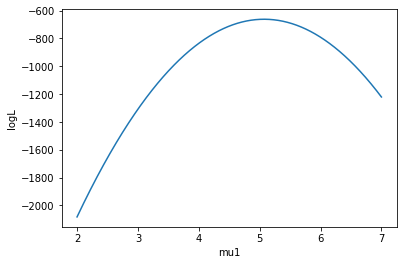

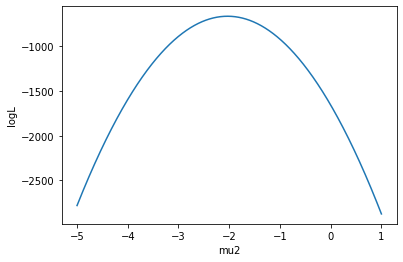

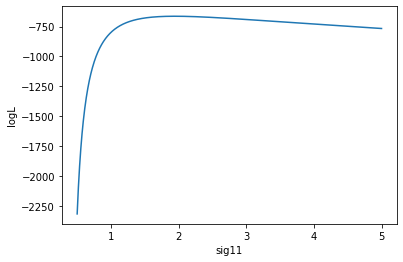

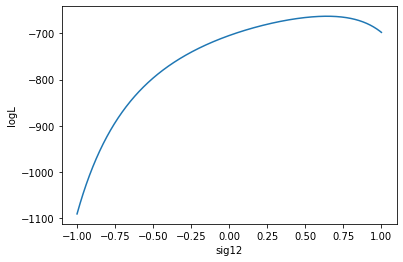

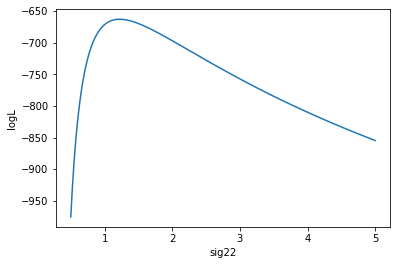

In [18]:
for item in ["mu1", "mu2", "sig11", "sig12", "sig22"]:
    tmp = SampleData(item).data
    tmp["logL"] = tmp.apply(lambda q: logL(X, q[0:2], np.array([[q[2],q[3]], [q[3], q[4]]])), axis=1)
    plt.plot(tmp[item], tmp["logL"])
    plt.xlabel(item)
    plt.ylabel("logL")
    plt.show()

Problem 3: Gaussian Process 

[76, 77, 78, 79, 80, 81, 82, 83, 84, 85]


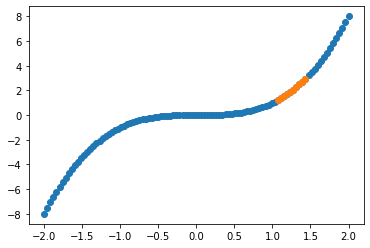

In [19]:
# Generate the entire dataset 
n = 100
x = np.linspace(-2, 2, num=n)
fx = x**3
# Index the known vs uknown data
obs = list(range( 75))
obs.extend(list(range(86, 100)))
y = list(range(76,86))
print(y)
X = x[obs]
# Plot the data
plt.scatter(x, fx)
plt.scatter(x[y], fx[y])

In [20]:
# test some values of sigf, l
l = 0.1
sigmaf = 0.1
distances = x - x[:, np.newaxis]
sigma = sigmaf**2 * np.exp(-(distances**2/l**2/2))

In [21]:
# Calculate Y | X 
sig11 = sigma[obs, :][:, obs]
sig22 = sigma[y, :][:, y]
sig12 = sigma[obs, :][:, y]
sig21 = sig12.T

sig11inv = LA.inv(sig11)
sigbar = sig22 - LA.multi_dot([sig21, sig11inv, sig12])
mubar = sig21 @ sig11inv @ fx[obs]

In [22]:
# Fit yhat 
yhat = np.random.multivariate_normal(mubar, sigbar)

Text(0.5, 1.0, 'Fitted Values')

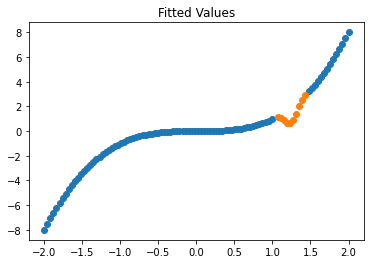

In [23]:
plt.scatter(x[obs], fx[obs])
plt.scatter(x[y], yhat)
plt.title("Fitted Values")

The values (.1, .1) were chosen because many other nearby values resutled in correlation matrices that were not full rank. Larger values resulted in worse fits. 

$Y | X$ is a good generic approximation of the true values of $Y$